In [1]:
import datetime as dt
import itertools as it
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from recsys4daos.utils import notebooks as nbutils
from recsys4daos.model_selection import cvtt_open
import paths

sns.set_theme(rc = {
})
sns.set_context("paper")

# Paper column width in inches
PAPER_COL_WIDTH = 3.5

original = plt.rcParamsDefault['figure.figsize']
ratio = original[0] / original[1]
print(f"Original size: {original}, Ratio: {ratio}")
plt.rcParams['figure.figsize'] = (PAPER_COL_WIDTH, PAPER_COL_WIDTH/ratio)
print("New size:", plt.rcParams['figure.figsize'])

# In acmart, 9pt is the default
# And 7pt for \footnotesize
# plt.rcParams['font.size'] = 7,

# The following are already relatively defined
# plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = plt.rcParams['axes.labelsize'] = plt.rcParams['font.size']

Original size: [6.4, 4.8], Ratio: 1.3333333333333335
New size: [3.5, 2.6249999999999996]


/home/daviddavo/recsys4daos/src/recsys4daos/model_selection.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
ORG_NAME = 'Decentraland'
SPLITS_FREQ: str = 'W-THU'
SPLITS_NORMALIZE: bool = True
LAST_FOLDS: int = 10
LAST_FOLD_DATE_STR: str = None # Used just for plotting

# Plotting hparams
RECTANGLE_ALPHA = 0.3

In [3]:
# Parameters
EXECUTION_ID = "2024-09-24T10:00"
ORG_NAME = "Frax"
SPLITS_FREQ = "5d"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = "2022-05-26"


In [4]:
LAST_FOLD_DATE: dt.datetime = dt.datetime.fromisoformat(LAST_FOLD_DATE_STR) if LAST_FOLD_DATE_STR else dt.datetime.now()

In [5]:
dfp = paths.load_proposals(ORG_NAME)
dfv = paths.load_votes(ORG_NAME)

print(dfp.info())
print(dfv.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359 entries, 0 to 358
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 359 non-null    object        
 1   author             359 non-null    object        
 2   date               359 non-null    datetime64[us]
 3   start              359 non-null    datetime64[us]
 4   end                359 non-null    datetime64[us]
 5   platform_proposal  359 non-null    object        
dtypes: datetime64[us](3), object(3)
memory usage: 17.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10184 entries, 0 to 10183
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        10184 non-null  object        
 1   proposal  10184 non-null  object        
 2   voter     10184 non-null  object        
 3   date      10184 non-null  datetime64[us]
dtypes:

In [6]:
print("First vote:", first_vote := dfv['date'].min())
print("Last vote:", last_vote := dfv['date'].max())
paths.save_dao_datum(ORG_NAME, 'dfv_first_vote', str(first_vote))
paths.save_dao_datum(ORG_NAME, 'dfv_last_vote', str(last_vote))

First vote: 2021-02-10 22:33:15
Last vote: 2023-07-19 16:12:02


In [7]:
folds = list(cvtt_open(dfv, SPLITS_FREQ, dfp, normalize=SPLITS_NORMALIZE, col_item='proposal', col_time='date', last_fold=LAST_FOLD_DATE_STR))[-LAST_FOLDS:]
print(f"Using {len(folds)} folds from {folds[0].end} to {folds[-1].end}")
paths.save_dao_datum(ORG_NAME, 'first_fold_date', str(folds[0].end))

Using 10 folds from 2022-04-11 00:00:00 to 2022-05-26 00:00:00


## Proposals and time

### How much time does each proposal take

5 days 00:00:00     233
3 days 00:00:00      57
7 days 00:00:00       7
2 days 00:00:00       7
4 days 00:00:00       6
6 days 00:00:00       6
1 days 00:00:00       5
5 days 06:00:00       2
5 days 16:37:02       1
6 days 14:39:15       1
6 days 16:24:11       1
7 days 02:12:28       1
6 days 20:49:04       1
6 days 23:40:44       1
5 days 00:09:29       1
14 days 00:00:00      1
0 days 00:37:18       1
4 days 13:47:32       1
6 days 10:51:50       1
6 days 13:18:17       1
6 days 23:46:14       1
4 days 01:02:43       1
7 days 01:09:26       1
4 days 00:38:59       1
3 days 23:59:43       1
4 days 00:29:05       1
3 days 22:00:00       1
4 days 23:00:24       1
2 days 22:00:00       1
0 days 06:00:00       1
3 days 13:00:00       1
2 days 19:15:00       1
21 days 00:00:00      1
6 days 01:00:00       1
3 days 08:00:00       1
3 days 06:00:00       1
3 days 23:40:31       1
5 days 04:00:00       1
14 days 01:00:00      1
7 days 07:00:00       1
3 days 02:00:00       1
6 days 00:05:00 

count                       359
mean     4 days 16:29:15.161559
std      1 days 14:11:49.024745
min             0 days 00:37:18
25%             4 days 17:17:01
50%             5 days 00:00:00
75%             5 days 00:00:00
max            21 days 00:00:00
dtype: object

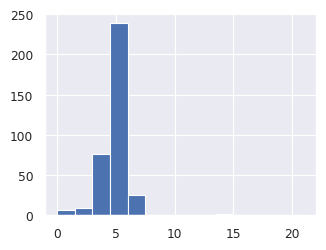

In [8]:
# Original: Cell [5] at https://github.com/daviddavo/upm-tfm-notebooks/blob/bb2e45d4ec10962c987b6691fcb0cd4eeba7ea5b/10_baseline_mp.ipynb

delta = dfp['end'] - dfp['start']
delta.dt.days.hist(bins=14)
print(vc := delta.value_counts())
print(vc / len(delta))
paths.save_dao_datum(ORG_NAME, 'median_open_time', str(delta.median()))
delta.describe()

#### Avg. proposal length in time

In [9]:
def add_folds_to_plot(fig=plt, cont=True):

    if cont:
        start_date = folds[0].end
        end_date = folds[-1].end
        fig.axvspan(start_date, end_date, color='C2', alpha=RECTANGLE_ALPHA)
    else:
        for fprev, f, c in zip(folds, folds[1:], it.cycle([0,1])):
            start_date = fprev.end
            end_date = f.end
            fig.axvspan(start_date, end_date, alpha=RECTANGLE_ALPHA, color='C1' if c else 'C2')

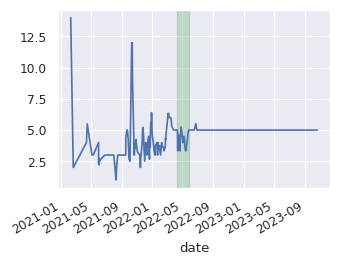

In [10]:
# Original: Cell [6] at https://github.com/daviddavo/upm-tfm-notebooks/blob/bb2e45d4ec10962c987b6691fcb0cd4eeba7ea5b/10_baseline_mp.ipynb
ROLLING_LENGTH = '7d'

_delta = dfp.assign(delta=delta).set_index('date').sort_index()['delta'].dt.days
_delta.rolling(ROLLING_LENGTH).mean().plot()

add_folds_to_plot()

## How many proposals are created per week

16.0
2023-01-30 17:36:34


<Figure size 350x262.5 with 0 Axes>

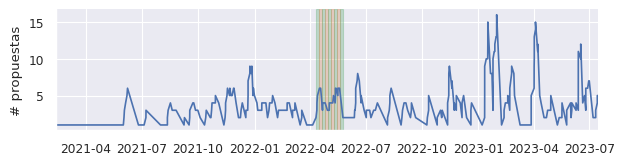

In [11]:
WINDOW_SIZE = '7d' # dt.timedelta(days=7)

_toplot = dfv.groupby('proposal')['date'].min().sort_values()
_toplot = _toplot.to_frame()
_toplot['cnt'] = 1
_toplot = _toplot.rolling(window=WINDOW_SIZE, on='date').count()
print(max_cnt := _toplot['cnt'].max())
print(max_date := _toplot[_toplot['cnt'] == max_cnt].iloc[0]['date'])
paths.save_dao_datum(ORG_NAME, 'max_proposals_ws', WINDOW_SIZE)
paths.save_dao_datum(ORG_NAME, 'max_proposals_cnt', int(max_cnt))
paths.save_dao_datum(ORG_NAME, 'max_proposals_date', str(max_date))

# Double the width of the figure
fs = plt.gcf().get_size_inches()
plt.figure(figsize=fs * (2,.6))
# _toplot.set_index('date')['cnt'].plot()
ax = sns.lineplot(_toplot.set_index('date')['cnt'])

plt.xlabel('')
plt.ylabel('# propuestas')
plt.xlim(
    _toplot['date'].min(),
    _toplot['date'].max(),
)
add_folds_to_plot(cont=False)

sns.despine()

<Figure size 350x262.5 with 0 Axes>

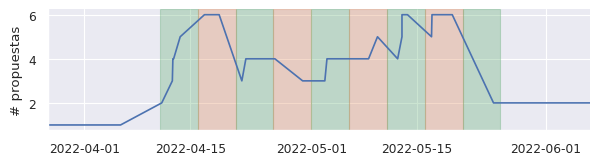

In [12]:
_toplot = _toplot[_toplot['date'] > (folds[0].end - pd.tseries.frequencies.to_offset(SPLITS_FREQ)*3)]
_toplot = _toplot[_toplot['date'] < (folds[-1].end + pd.tseries.frequencies.to_offset(SPLITS_FREQ)*3)]
fs = plt.gcf().get_size_inches()
plt.figure(figsize=fs * (2,.6))
# _toplot.set_index('date')['cnt'].plot()
ax = sns.lineplot(_toplot.set_index('date')['cnt'])

plt.xlabel('')
plt.ylabel('# propuestas')
plt.xlim(
    _toplot['date'].min(),
    _toplot['date'].max(),
)
add_folds_to_plot(cont=False)

sns.despine()

## Queue size (open proposals)

12
2023-06-16 12:00:00


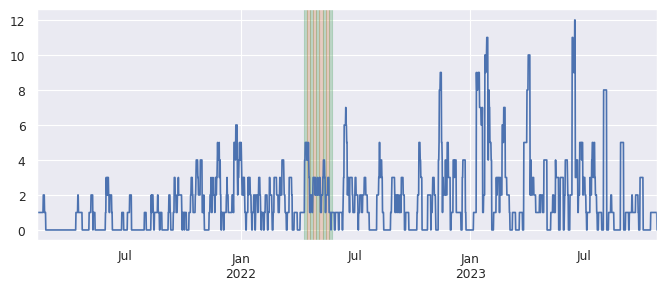

In [13]:
# This will be the "resolution" of the graph
_GROUPER_FREQ = '12h'

df_events = pd.concat((
    dfp.groupby('start').size(),
    -dfp.groupby('end').size(),
)).sort_index()
qsize = df_events.groupby(pd.Grouper(freq=_GROUPER_FREQ)).sum().cumsum()

print(max_qsize := qsize.max())
print(max_date := qsize[qsize == max_qsize].index[0])
paths.save_dao_datum(ORG_NAME, 'max_open_freq', _GROUPER_FREQ)
paths.save_dao_datum(ORG_NAME, 'max_open_cnt', int(max_qsize))
paths.save_dao_datum(ORG_NAME, 'max_open_date', str(max_date))

qsize.plot(figsize=(8,3))
add_folds_to_plot(cont=False)

5
2022-04-13 12:00:00


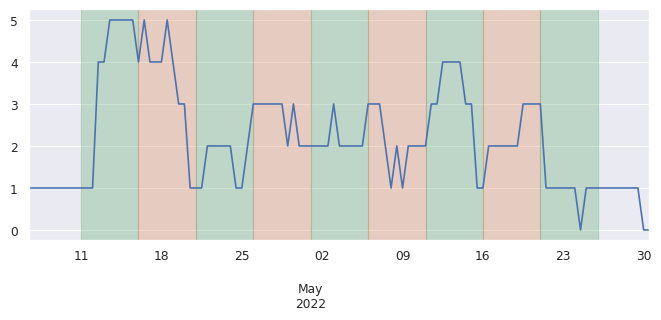

In [14]:
_toplot = qsize[qsize.index > (folds[0].end - pd.tseries.frequencies.to_offset(SPLITS_FREQ)*1)]
_toplot = _toplot[_toplot.index < (folds[-1].end + pd.tseries.frequencies.to_offset(SPLITS_FREQ)*1)]

print(max_qsize := _toplot.max())
print(max_date := _toplot[_toplot == max_qsize].index[0])
paths.save_dao_datum(ORG_NAME, 'max_open_freq_test', _GROUPER_FREQ)
paths.save_dao_datum(ORG_NAME, 'max_open_cnt_test', int(max_qsize))
paths.save_dao_datum(ORG_NAME, 'max_open_date_test', str(max_date))

_toplot.plot(figsize=(8,3))
add_folds_to_plot(cont=False)

## What day of the week are proposals created

start
Monday       75
Tuesday      67
Friday       57
Wednesday    51
Thursday     45
Saturday     34
Sunday       30
Name: count, dtype: int64


/tmp/ipykernel_1808721/3307774390.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(DAYS_OF_WEEK_ENG, rotation=30, ha='right')


Cannot show ipywidgets in text

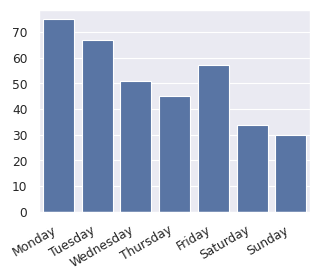

In [15]:
# Original: Cell [7] at https://github.com/daviddavo/upm-tfm-notebooks/blob/bb2e45d4ec10962c987b6691fcb0cd4eeba7ea5b/10_baseline_mp.ipynb
DAYS_OF_WEEK_ENG = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

ax = sns.countplot(x=dfp['start'].dt.day_name(), order=DAYS_OF_WEEK_ENG)
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
print(dfp['start'].dt.day_name().value_counts())
ax.set_xlabel('')
ax.set_ylabel('# proposals')
ax.set_xticklabels(DAYS_OF_WEEK_ENG, rotation=30, ha='right')

# Updates
ax.set_ylabel('')

nbutils.download_matplotlib(ax.figure, 'proposals_dow.pdf')

## What day of the week are proposals voted

date
Wednesday    1677
Tuesday      1675
Thursday     1482
Friday       1465
Monday       1396
Saturday     1341
Sunday       1148
Name: count, dtype: int64


/tmp/ipykernel_1808721/3643726510.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(DAYS_OF_WEEK_ENG, rotation=30, ha='right')


Cannot show ipywidgets in text

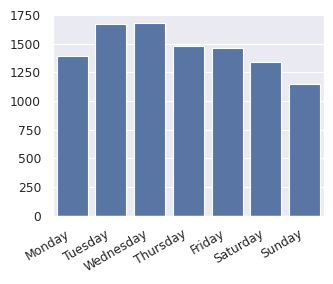

In [16]:
ax = sns.countplot(x=dfv['date'].dt.day_name(), order=DAYS_OF_WEEK_ENG)
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
print(dfv['date'].dt.day_name().value_counts())
ax.set_xlabel('')
ax.set_ylabel('# votes')
ax.set_xticklabels(DAYS_OF_WEEK_ENG, rotation=30, ha='right')

# Updates
ax.set_ylabel('')

nbutils.download_matplotlib(ax.figure, "votes_dow.pdf")

## In which moment of the proposal lifetime are votes cast

time remaining                                          \
                          count      mean       std       min       25%   
delta                                                                     
0 days 06:00:00             2.0  0.258449  0.293613  0.050833  0.154641   
1 days 00:00:00            56.0  0.580636  0.324479  0.019560  0.224873   
2 days 00:00:00           151.0  0.501104  0.283726  0.019543  0.258837   
2 days 19:15:00            16.0  0.611742  0.322400  0.021537  0.388171   
2 days 22:00:00            37.0  0.641673  0.250398  0.030115  0.484829   
3 days 00:00:00          1572.0  0.626063  0.284590  0.000367  0.406686   
3 days 02:00:00           103.0  0.748649  0.274583  0.094452  0.572166   
3 days 06:00:00            90.0  0.585474  0.215791  0.005367  0.506504   
3 days 08:00:00            64.0  0.694326  0.240458  0.071524  0.632030   
3 days 13:00:00            23.0  0.751865  0.198009  0.115147  0.675825   
3 days 22:00:00            26.0  0.624485  0.284991  0.023333  0.501336   
3 days 23:40:31            22.0  0.431162  0.171989  0.115724  0.344427   
3 days 23:59:43            34.0  0.436114  0.254813  0.030728  0.308836   
4 days 00:00:00           127.0  0.558669  0.263812  0.035182  0.358089   
4 days 00:29:05            18.0  0.578524  0.313634  0.073952  0.298573   
4 days 00:38:59            38.0  0.630527  0.247360  0.114307  0.450135   
4 days 01:02:43            36.0  0.583102  0.306781  0.033306  0.299268   
4 days 13:47:32            37.0  0.526786  0.321571  0.006269  0.279748   
4 days 20:46:30            41.0  0.763341  0.259731  0.029342  0.657528   
4 days 23:00:24            40.0  0.741850  0.192875  0.209991  0.625860   
5 days 00:00:00          6403.0  0.612926  0.290820  0.000998  0.376007   
5 days 00:00:58            49.0  0.562971  0.258733  0.072347  0.338510   
5 days 00:09:29            60.0  0.559141  0.257448  0.021495  0.412285   
5 days 04:00:00            42.0  0.699465  0.240725  0.024326  0.578053   
5 days 06:00:00            93.0  0.667845  0.252163  0.010421  0.528122   
5 days 16:37:02            52.0  0.610024  0.262229  0.041214  0.397675   
6 days 00:00:00           219.0  0.613412  0.274796  0.024552  0.401729   
6 days 00:05:00            22.0  0.799837  0.249328  0.123609  0.689754   
6 days 01:00:00            16.0  0.643312  0.224942  0.039086  0.523704   
6 days 10:51:50            33.0  0.494857  0.366001  0.032175  0.093066   
6 days 13:18:17            45.0  0.534661  0.284381  0.053599  0.289451   
6 days 14:39:15            35.0  0.524269  0.252594  0.014163  0.351414   
6 days 16:24:11            25.0  0.558029  0.316895  0.030647  0.303020   
6 days 20:49:04            43.0  0.511210  0.372265  0.015804  0.070717   
6 days 23:40:44            28.0  0.498778  0.375200  0.001105  0.072026   
6 days 23:46:14            34.0  0.694474  0.241513  0.038803  0.553987   
7 days 00:00:00           248.0  0.677332  0.312739  0.000473  0.504237   
7 days 01:09:26            49.0  0.626656  0.309861  0.003283  0.333160   
7 days 02:12:28            30.0  0.585129  0.284003  0.008886  0.407501   
7 days 07:00:00            20.0  0.652545  0.234227  0.257051  0.439051   
14 days 00:00:00           47.0  0.520722  0.275945  0.185818  0.260659   
14 days 01:00:00           39.0  0.715238  0.213879  0.184336  0.584455   
21 days 00:00:00           19.0  0.809854  0.179648  0.238807  0.763377   

                                                
                       50%       75%       max  
delta                                           
0 days 06:00:00   0.258449  0.362257  0.466065  
1 days 00:00:00   0.646649  0.858750  0.982627  
2 days 00:00:00   0.496800  0.741108  0.998316  
2 days 19:15:00   0.705929  0.890868  0.999926  
2 days 22:00:00   0.739024  0.739964  0.997591  
3 days 00:00:00   0.687907  0.865062  0.999923  
3 days 02:00:00   0.866978  0.973636  0.999373  
3 days 06:00:00   0.576770  0.738741  0.995759  
3 days 08:00:00   0.746273 

2776 (27.26%) of the votes are being cast on the first 14.29% of rel time
9383 (92.13%) of the votes are being cast on the first 85.71% of rel time


Cannot show ipywidgets in text

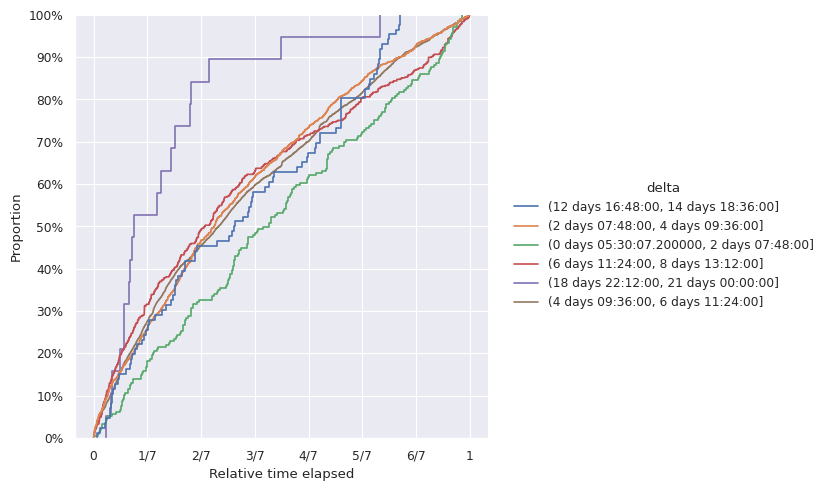

In [17]:
from matplotlib import ticker

PLOT_HUE = True
BINS = 10

_dfv = dfv[['proposal', 'date']].merge(dfp[['id', 'start', 'end']], left_on='proposal', right_on='id').sort_values('date')
if not all(_dfv['date'] >= _dfv['start']):
    warnings.warn('There cant be votes before the proposal started')
if not all(_dfv['end'] >= _dfv['date']):
    warnings.warn('There cant be votes after the proposal ended')
_dfv['date_rel'] = (_dfv['date'] - _dfv['start']) / (_dfv['end'] - _dfv['start'])
_dfv['delta'] = (_dfv['end'] - _dfv['start'])
_dfv['time remaining'] = 1 - _dfv['date_rel']

display(_dfv.groupby('delta')[['time remaining']].describe())

for t in [1/7, 6/7]:
    first_day = (_dfv['date_rel'] < t)
    print(f"{first_day.sum()} ({first_day.mean()*100:.2f}%) of the votes are being cast on the first {t*100:.2f}% of rel time")

if len(_dfv['delta'].value_counts()) > BINS:
    _dfv['delta_original'] = _dfv['delta']
    _dfv['delta'] = pd.cut(_dfv['delta'], BINS)

_dfv['delta'] = _dfv['delta'].astype(str)
fg = sns.displot(_dfv, x='date_rel', kind='ecdf', hue='delta' if PLOT_HUE else None)
# fg.ax.xaxis.set_major_locator(ticker.MultipleLocator(1/7))

fg.ax.yaxis.set_major_locator(ticker.MultipleLocator(1/10))
fg.ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))
fg.ax.set_xticks(np.arange(8)/7)
fg.ax.set_xticklabels(["0"] + [f"{x}/7" for x in range(1,7)] + ["1"])
fg.ax.set_xlabel('Relative time elapsed');

nbutils.download_matplotlib(fg, f"votes_in_time{'-color' if PLOT_HUE else ''}.pdf")

## Explore folds

### Just the folds that are used

In [18]:
from collections import defaultdict

foldsinfo = defaultdict(list)
for f in folds:
    # print(len(f.open_proposals), "open proposals")
    foldsinfo['t'].append(f.end)
    foldsinfo['open proposals'].append(len(f.open_proposals))
    foldsinfo['users in train'].append(f.train['voter'].nunique())
    foldsinfo['users in test'].append(f.test['voter'].nunique())
    foldsinfo['votes in train'].append(len(f.train))
    foldsinfo['votes in test'].append(len(f.test))
    foldsinfo['users in both'].append(len(np.intersect1d(f.test['voter'].unique(), f.test['voter'].unique())))
    # votes per proposal
    foldsinfo['vpp test'].append(f.test.groupby('proposal').size().mean())
    # votes per voter
    foldsinfo['vpv test'].append(f.test.groupby('voter').size().mean())

dff = pd.DataFrame(foldsinfo).set_index('t')
paths.save_dao_datum(ORG_NAME, 'folds_avg_open_proposals', dff['open proposals'].mean())
paths.save_dao_datum(ORG_NAME, 'folds_avg_test_votes', dff['votes in test'].mean())
paths.save_dao_datum(ORG_NAME, 'folds_avg_test_users', dff['users in test'].mean())
paths.save_dao_datum(ORG_NAME, 'folds_avg_test_vpp', dff['vpp test'].mean())
paths.save_dao_datum(ORG_NAME, 'folds_avg_test_vpv', dff['vpv test'].mean())
dff

,open proposals,users in train,users in test,votes in train,votes in test,users in both,vpp test,vpv test
t,,,,,,,,
2022-04-11,1,643,1,3226,1,1,1.000000,1.000000
2022-04-16,5,652,29,3357,52,29,10.400000,1.793103
2022-04-21,1,685,11,3500,11,11,11.000000,1.000000
2022-04-26,2,701,46,3621,61,46,30.500000,1.326087
2022-05-01,2,707,33,3712,42,33,21.000000,1.272727
2022-05-06,2,716,23,3822,34,23,17.000000,1.478261
2022-05-11,2,731,16,3940,20,16,10.000000,1.250000
2022-05-16,1,736,4,4054,4,4,4.000000,1.000000
2022-05-21,3,740,28,4139,34,28,11.333333,1.214286


## Histograms

### Votes per user

count    1011.000000
mean       10.073195
std        22.511176
min         1.000000
10%         1.000000
15%         1.000000
50%         2.000000
90%        27.000000
95%        45.500000
99%       115.800000
max       255.000000
dtype: float64
209 voters (20.67%) have voted more than 10 times
18 voters (1.78%) have voted more than 100 times


Cannot show ipywidgets in text

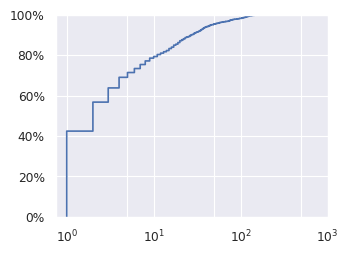

In [19]:
_toplot = dfv.groupby('voter').size()
# _toplot = _toplot[_toplot < 40]
print(_toplot.describe(percentiles=[.1, .15, .5, .9, .95, .99]))
# _toplot.plot.hist(log=True)
ax = sns.ecdfplot(_toplot, log_scale=True)
plt.xlabel('# votes')
plt.ylabel('% voters')

_times_voted = [10, 100]
for t in _times_voted:
    _nusers = (_toplot > t).sum()
    print(f"{_nusers} voters ({_nusers/len(_toplot)*100:.2f}%) have voted more than {t} times")

ax.set_xticks([1, 5, 10, 50, 100, 500, 1000])
# ax.xaxis.set_major_locator(mtick.MultipleLocator(10))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))

# Updates by Javi
plt.xlabel("")
plt.ylabel("")

nbutils.download_matplotlib(ax.figure, "ecdf-vpv.pdf")

### Votes per proposal

count    321.000000
mean      31.725857
std       13.590423
min        1.000000
10%       17.000000
15%       20.000000
20%       22.000000
25%       23.000000
50%       30.000000
75%       38.000000
90%       47.000000
95%       55.000000
99%       77.200000
max      103.000000
dtype: float64
Total votes: 10184
313 proposals (97.51%) have more than 10 votes
6 proposals (1.87%) have more than 72 votes
5 proposals (1.56%) have more than 73 votes
1 proposals (0.31%) have more than 100 votes


Cannot show ipywidgets in text

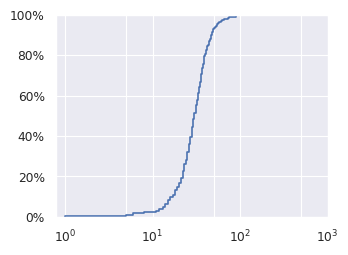

In [20]:
_toplot = dfv.groupby('proposal').size()
print(_toplot.describe(percentiles=[.1, .15, .20, .25, .5,.75,.9, .95, .99]))

print("Total votes:", _toplot.sum())
_times_voted = [10, 72, 73, 100]
for t in _times_voted:
    _nprops = (_toplot > t).sum()
    print(f"{_nprops} proposals ({_nprops/len(_toplot)*100:.2f}%) have more than {t} votes")

ax = sns.ecdfplot(_toplot, log_scale=True)
ax.set_xticks([1, 5, 10, 50, 100, 500, 1000])
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))

plt.xlabel('# votes')
plt.ylabel('% proposals')

# Updates by Javi
plt.xlabel("")
plt.ylabel("")

nbutils.download_matplotlib(ax.figure, "ecdf-vpp.pdf")